In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as Data

from torchsummary import summary

In [2]:
import yfinance as yf

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data = pd.read_csv("NVDA.csv")
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-05-28,21.22,21.58,21.18,21.51,8191400,0.0,0
1,2015-05-29,21.51,21.65,21.47,21.50,8379200,0.0,0
2,2015-06-01,21.64,21.96,21.50,21.75,9316500,0.0,0
3,2015-06-02,21.61,21.73,21.30,21.32,5607600,0.0,0
4,2015-06-03,21.38,21.54,21.05,21.09,6269700,0.0,0
...,...,...,...,...,...,...,...,...
1254,2020-05-20,359.64,361.72,355.55,358.80,14688400,0.0,0
1255,2020-05-21,362.06,362.10,349.50,351.01,19026700,0.0,0
1256,2020-05-22,353.01,363.72,348.53,361.05,25969100,0.0,0
1257,2020-05-26,366.27,367.27,346.88,348.71,19269500,0.0,0


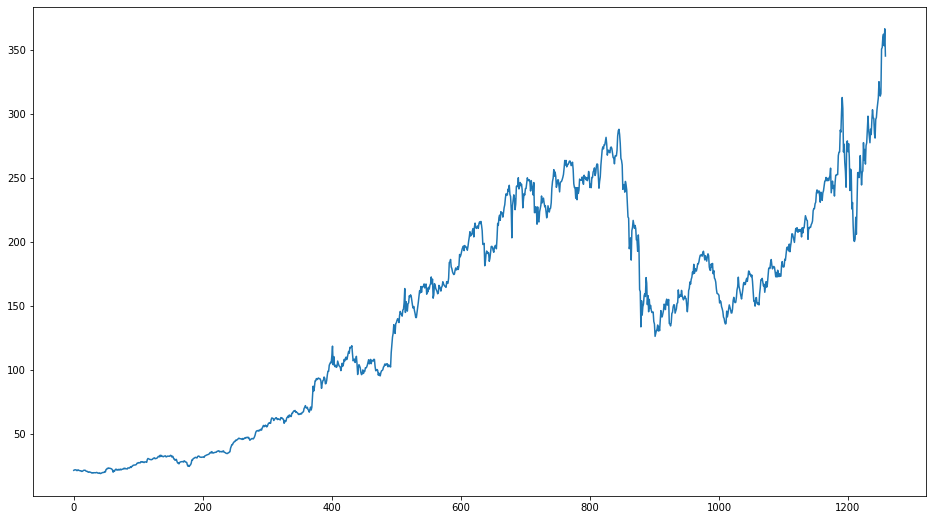

In [5]:
data['Open'].plot(figsize=(16, 9))

In [6]:
dataset_train = data
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
len(training_set)

1259

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
X_train = []
y_train = []
for i in range(60, len(training_set)-200):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [10]:
X_train.shape

torch.Size([999, 60])

In [11]:
y_train = y_train.reshape(1, len(X_train), -1)

In [12]:
y_train.shape

torch.Size([1, 999, 1])

In [13]:
X_train = X_train.reshape(1, len(X_train), 60)

In [14]:
X_train.shape

torch.Size([1, 999, 60])

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=4, dropout=0.1)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, inputs):
        output, hidden = self.lstm(inputs)
        out = self.linear(output)
        return(out)

In [16]:
model = LSTM(60, 70)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.to(device)

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.1)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

In [18]:
X_train = X_train.to(device)
X_train.device

device(type='cuda', index=0)

In [19]:
y_train = y_train.to(device)
y_train.device

device(type='cuda', index=0)

In [20]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.zero_grad()
    y_pred = model(X_train)
    loss= loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print("Epoch: ", epoch+1, "| Loss: ", float(loss))

Epoch:  1 | Loss:  0.09767136722803116
Epoch:  11 | Loss:  0.07074040174484253
Epoch:  21 | Loss:  0.044438984245061874
Epoch:  31 | Loss:  0.03592756763100624
Epoch:  41 | Loss:  0.023441733792424202
Epoch:  51 | Loss:  0.01321557629853487
Epoch:  61 | Loss:  0.008925612084567547
Epoch:  71 | Loss:  0.0067763314582407475
Epoch:  81 | Loss:  0.005265905521810055
Epoch:  91 | Loss:  0.004410159308463335
Epoch:  101 | Loss:  0.0036273484583944082
Epoch:  111 | Loss:  0.0031181229278445244
Epoch:  121 | Loss:  0.0026093716733157635
Epoch:  131 | Loss:  0.0022839584853500128
Epoch:  141 | Loss:  0.002089671790599823
Epoch:  151 | Loss:  0.001979497028514743
Epoch:  161 | Loss:  0.0017869002185761929
Epoch:  171 | Loss:  0.00168124632909894
Epoch:  181 | Loss:  0.0016695557860657573
Epoch:  191 | Loss:  0.0014510008040815592
Epoch:  201 | Loss:  0.0014930622419342399
Epoch:  211 | Loss:  0.0014507579617202282
Epoch:  221 | Loss:  0.0012337254593148828
Epoch:  231 | Loss:  0.0012581046903505

In [21]:
model.to("cpu")

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.1)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

## Test

In [22]:
# Getting the stock price of 2020
dataset_test = pd.read_csv("NVDA.csv")
dataset_test = dataset_test.iloc[-200:]
len(dataset_test)

200

In [23]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [24]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = torch.Tensor(X_test)
X_test = X_test.reshape(1, len(X_test), 60)
predicted_stock_price = model(X_test)
predicted_stock_price = torch.Tensor.cpu(predicted_stock_price).detach().numpy()[-1]
predicted_stock_price = sc.inverse_transform(np.array(predicted_stock_price))

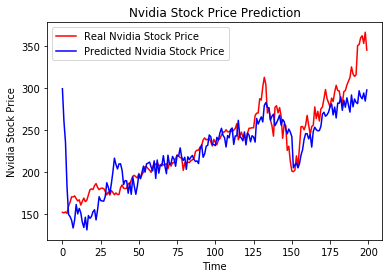

In [25]:
plt.plot(real_stock_price, color = 'red', label = 'Real Nvidia Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')
plt.legend()
plt.show()